### **Эксперимент 9.**

Построить отдельные модели для высот (ALT) 0-500, 500-1000, 1000-1500. Результат смотрим суммарно. 

Использовать конфигурацию эксперимента 5 (или 4, если лучше)


In [2]:
import pandas as pd
import numpy as np 

y_cols = ['egtm']
meta_cols = ['reportts', 'acnum', 'pos']
features = ['egt', 'tat', 'n1a', 'n2a', 'wai', 'nai', 'prv', 'alt', 'mn', 'ff', 'nf']

In [3]:
from utils import *

fleet = ['VQ-BGU', 'VQ-BDU']

bgu = pd.read_csv('./takeoff-merged-VQ-BGU-30s.csv', parse_dates=['reportts']).dropna(subset=['egtm'])
bdu = pd.read_csv('./takeoff-merged-VQ-BDU-30s.csv', parse_dates=['reportts']).dropna(subset=['egtm'])

data = build_dataset(
  [bgu, bdu], 
  y_cols, 
  meta_cols, 
  features,
  n_back=13,
)

Plot altitude to determine best bins

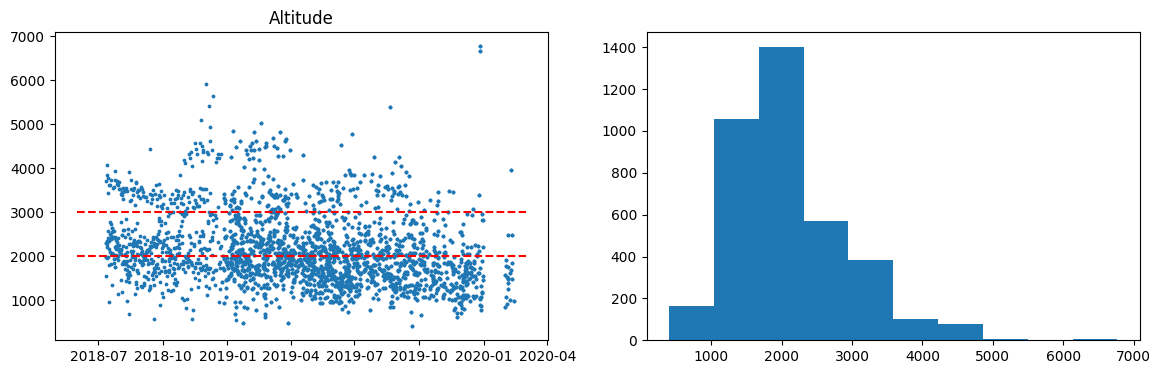

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 4))

ax1 = plt.subplot(1, 2, 1)
plt.title('Altitude')
ax1.scatter(data['reportts'], data['alt'], s=3)
x = (pd.to_datetime('2018-06-01'), pd.to_datetime('2020-03-01'))
ax1.plot(x, (3000, 3000), '--', color='red')
ax1.plot(x, (2000, 2000), '--', color='red')
ax2 = plt.subplot(1, 2, 2)
ax2.hist(data['alt'])

plt.show()

In [5]:
from sklearn.linear_model import LinearRegression
from training import *
from typing import List

def predict_ensemble(models: List[LinearRegression], X: pd.DataFrame, field: str='alt', bins: List[List[float]]=[]):
  pred = pd.DataFrame(index=X.index.copy(), columns=['pred'])
  for i, [bottom, top] in enumerate(bins):
    index = (X[field] > bottom) & (X[field] <= top)
    pred.loc[index, 'pred'] = models[i].predict(X[index])
  return pred

def filter_split_by_field(X: pd.DataFrame, y: pd.DataFrame, field: str, bin: List[float]):
  bottom, top = bin
  index = (X[field] > bottom) & (X[field] <= top)
  return X[index], y[index]

def train_ensemble_model(X, y, model = 'linreg', field: str='alt', bins: List[List[str]]=[]):
  assert len(X) == len(y)

  train_i = int(len(X) * 75 / 100)
  X_train, y_train = X[0:train_i], y[0:train_i]
  X_test, y_test = X[train_i:], y[train_i:]

  ensemble = {i: LinearRegression() for i in range(len(bins)) }

  assert len(ensemble) == len(bins)

  for i, bin in enumerate(bins):
    X_train_f, y_train_f = filter_split_by_field(X_train, y_train, field, bin)
    ensemble[i].fit(X_train_f, y_train_f)
  
  predicted_train = predict_ensemble(ensemble, X_train, field, bins)
  predicted_test = predict_ensemble(ensemble, X_test, field, bins)

  return get_metrics(y_test, predicted_test), model, predicted_train, predicted_test, train_i, y_test

In [6]:
X = data.drop(columns=(meta_cols + y_cols))
y = data['egtm']

metrics, model, predicted_train, predicted_test, train_i, y_test =  \
  train_ensemble_model(
    X, y, 'alt', 
    bins=[[0, 3000], [3000, 10_000]]
  )

print(f'Altitude ensemble: {metrics}')

Altitude ensemble: {'rmse': 1.82869, 'mae': 1.491, 'r2': 0.40104, 'mape': 0.07258}


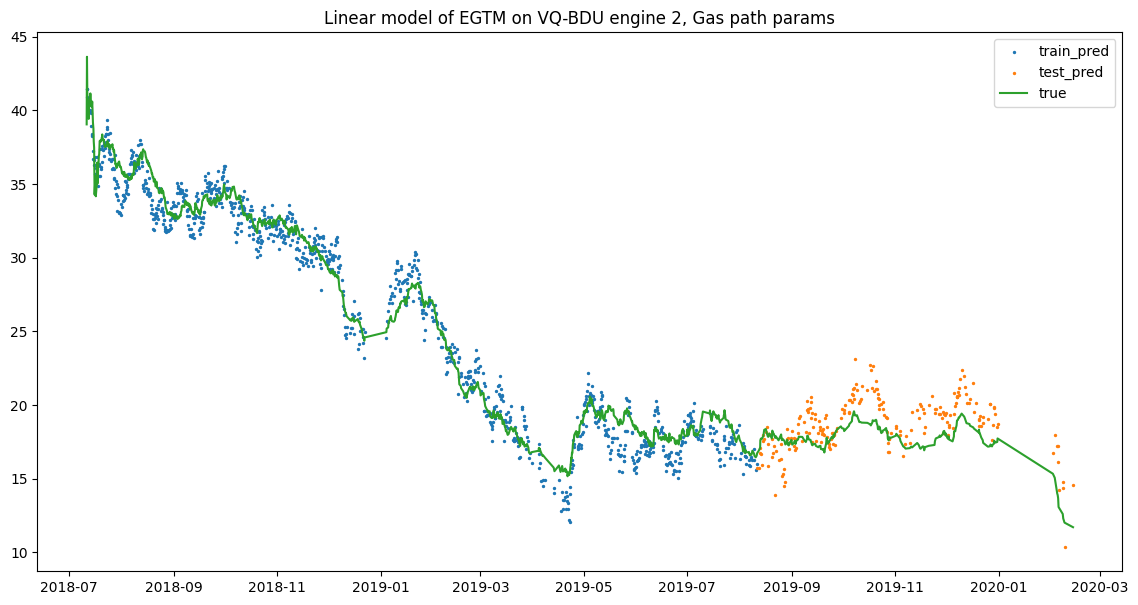

In [7]:
plot_predictions(data, 'VQ-BDU', 2, train_i, predicted_test['pred'], predicted_train['pred'], is_smooth=False)

In [10]:
def correct(data):
  datak = data.copy()
  alpha = 0.5
  theta = (data['tat'] + 273.15) / 288.15
  delta = data['p2e'] + 1013.25

  datak['nfk'] = data['nf'] / (theta ** alpha)
  datak['n1ak'] = data['n1a'] / (theta ** alpha)
  datak['n2ak'] = data['n2a'] / (theta ** alpha)
  datak['egtk'] = (data['egt'] + 273.15) / theta
  datak['ffk'] = (data['ff']) / (delta * (theta ** alpha))

  return datak

features_k = ['egtk', 'tat', 'n1a', 'n2a', 'wai', 'nai', 'prv', 'alt', 'mn', 'ffk', 'nf']

datak = build_dataset(
  [correct(bgu), correct(bdu)], 
  y_cols, 
  meta_cols, 
  features_k,
  n_back=13,
)

In [12]:
X = datak.drop(columns=(meta_cols + y_cols))
y = datak['egtm']

metrics, model, predicted_train, predicted_test, train_i, y_test =  \
  train_ensemble_model(
    X, y, 'alt', 
    bins=[[0, 2000], [2000, 3000], [3000, 10_000]]
  )

print(f'Altitude ensemble with corrections: {metrics}')

Altitude ensemble with corrections: {'rmse': 1.71497, 'mae': 1.39275, 'r2': 0.47322, 'mape': 0.06792}
